In [16]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="whitegrid", context='notebook', color_codes=True)

from haversine import haversine

The goal of this notebook is convert our cleaned events dataset to a format that is suitable for classification algorithm.

Input Datasets:
- Cleaned Events Data: `data/events_no_duplicates.csv`
- Cleaned IATA Data: `data/iata_no_duplicates.csv`

Intuitions:
1. Users that search multiple times will mostly book a trip.
2. Users will most likely book when destination is far from their origin.
3. Users will most likely book based on the number of vacation days.

# Events Dataset

In [5]:
filepath = "data/events_no_duplicates.csv"
dataset = pd.read_csv(filepath)

In [6]:
dataset.head()

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children
0,2017-04-27 11:06:51,search,60225f,2017-06-01,2017-06-07,PAR,NYC,6,1
1,2017-04-27 20:15:27,book,e5d69e,2017-08-12,2017-09-02,FRA,WAS,3,1
2,2017-04-27 23:03:43,book,f953f0,2017-10-08,2017-10-11,BER,CGN,2,0
3,2017-04-27 15:17:50,book,794d35,2017-04-28,2017-05-01,BER,BCN,1,0
4,2017-04-27 22:51:57,book,ca4f94,2017-05-16,2017-05-22,DEL,BKK,4,0


In [12]:
dataset['date_from'] = pd.to_datetime(dataset['date_from'])
dataset['date_to'] = pd.to_datetime(dataset['date_to'])
dataset['num_days'] = (dataset['date_to'] - dataset['date_from']).dt.days
dataset.head()

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children,num_days
0,2017-04-27 11:06:51,search,60225f,2017-06-01,2017-06-07,PAR,NYC,6,1,6
1,2017-04-27 20:15:27,book,e5d69e,2017-08-12,2017-09-02,FRA,WAS,3,1,21
2,2017-04-27 23:03:43,book,f953f0,2017-10-08,2017-10-11,BER,CGN,2,0,3
3,2017-04-27 15:17:50,book,794d35,2017-04-28,2017-05-01,BER,BCN,1,0,3
4,2017-04-27 22:51:57,book,ca4f94,2017-05-16,2017-05-22,DEL,BKK,4,0,6


# Calculating geo distance

I use haversine formula to calculate the distance between 2 places.

In [15]:
iata = pd.read_csv('data/iata_no_duplicates.csv').set_index('iata_code')

In [35]:
geo_distances = {}

def calculate_distance(x):
    origin = x['origin']
    destination = x['destination']
    key = f"{origin}-{destination}"
    
    if key not in geo_distances:   
        origin_geo = iata.loc[origin]
        origin_point = (origin_geo['lat'], origin_geo['lon'])
    
        dest_geo = iata.loc[destination]
        dest_point = (dest_geo['lat'], dest_geo['lon'])
        
        geo_distances[key] = haversine(origin_point, dest_point)
    
    return geo_distances[key] 

In [32]:
dataset['geo_distance'] = dataset.apply(lambda x: calculate_distance(x), axis=1)

In [36]:
dataset.head()

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children,num_days,geo_distance
0,2017-04-27 11:06:51,search,60225f,2017-06-01,2017-06-07,PAR,NYC,6,1,6,5837.828026
1,2017-04-27 20:15:27,book,e5d69e,2017-08-12,2017-09-02,FRA,WAS,3,1,21,6530.035012
2,2017-04-27 23:03:43,book,f953f0,2017-10-08,2017-10-11,BER,CGN,2,0,3,470.077408
3,2017-04-27 15:17:50,book,794d35,2017-04-28,2017-05-01,BER,BCN,1,0,3,1499.761224
4,2017-04-27 22:51:57,book,ca4f94,2017-05-16,2017-05-22,DEL,BKK,4,0,6,2923.178366


# Let's calculate how many searches before the user book a trip

In [50]:
columns = ['user_id', 'date_from', 'date_to', 'origin', 'destination']
grouped_data = dataset.groupby(columns)

new_dataset = []
for index, group in grouped_data:
    obj = dict(zip(columns, index))
    booked_data = group[group['event_type'] == 'book']
    data = group.iloc[0]
    
    if not booked_data.empty:
        obj['is_booked'] = 1
        data = booked_data.iloc[0]
    else:
        obj['is_booked'] = 0
                        
    obj['search_count'] = group[group['event_type'] == 'search'].shape[0]
    obj['num_adults'] = data['num_adults']
    obj['num_children'] = data['num_children']
    obj['num_days'] = data['num_days']
    obj['geo_distance'] = data['geo_distance']
    
    new_dataset.append(obj)
    
grouped_dataset = pd.DataFrame(new_dataset)
      

In [51]:
grouped_dataset

,user_id,date_from,date_to,origin,destination,is_booked,search_count,num_adults,num_children,num_days,geo_distance
0,000069,2017-05-10,2017-05-26,FRA,ALG,0,1,2,3,16,1553.717725
1,00019d,2017-09-15,2017-10-13,PAR,SSA,0,1,4,0,28,7944.570036
2,0002e3,2017-05-01,2017-05-01,PAR,ATH,0,1,1,0,0,2095.453304
3,000332,2017-06-08,2017-07-07,NCE,TLV,0,3,1,0,29,2722.329760
4,000332,2017-06-08,2017-07-07,TLV,NCE,0,1,2,0,29,2722.329760
...,...,...,...,...,...,...,...,...,...,...,...
36275,fff74a,2017-05-31,2017-06-03,BER,PMI,0,1,1,0,3,1657.197524
36276,fff86d,2017-09-07,2017-09-27,PAR,AKL,0,1,1,0,20,18563.553561
36277,fff8fc,2017-08-16,2017-09-07,PAR,DPS,0,1,2,2,22,12400.206143
36278,fff95a,2017-05-08,2017-05-08,MUC,BOM,0,1,1,0,0,6326.189531


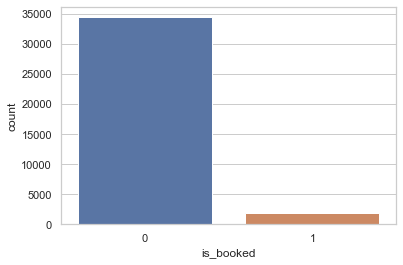

In [52]:
sns.countplot(x='is_booked', data=grouped_dataset)

In [53]:
grouped_dataset['is_booked'].value_counts()

0    34474
1     1806
Name: is_booked, dtype: int64

In [56]:
grouped_dataset.to_csv('data/transformed_dataset.csv', index=False)